In [1]:
# !pip install tweepy==4.10.0
# !pip install python-dotenv

In [2]:
import tweepy
from dotenv import load_dotenv
import os
import csv
import datetime
import string

In [3]:
# Load device's environment. 
dotenv_path = os.path.abspath('twitter.env')
load_dotenv(dotenv_path)

# Get tokens.
CONSUMER_KEY = os.environ['CONSUMER_KEY']
CONSUMER_SECRET = os.environ['CONSUMER_SECRET']
ACCESS_TOKEN = os.environ['ACCESS_TOKEN']
ACCESS_TOKEN_SECRET = os.environ['ACCESS_TOKEN_SECRET']
BEARER_TOKEN = os.environ['BEARER_TOKEN']

# Authentication with Twitter.
Client = tweepy.Client(bearer_token=BEARER_TOKEN, consumer_key=CONSUMER_KEY, 
consumer_secret=CONSUMER_SECRET, access_token=ACCESS_TOKEN, access_token_secret=ACCESS_TOKEN_SECRET)

# Get tweets from twitter and write into CSV

\#MarcosTheRealHero for positive sentiment (1)

\#MarcosNotAHero for negative sentiment (0)

Output CSV is named `naive_labeled_data.csv` with two columns, `text` (the tweet) and `sentiment` (0 or 1)


In [4]:
f = open('naive_labeled_data.csv', 'w+', encoding='UTF8', newline='')
writer = csv.writer(f)
writer.writerow(['text', 'sentiment'])

16

In [5]:
HASHTAG = '#MarcosNotAHero'
NUM_TWEETS = 100
START_TIME = datetime.datetime(2022, 9, 7)

In [6]:
tweets = Client.search_recent_tweets(query = HASHTAG, max_results = NUM_TWEETS, tweet_fields=['lang'])[0]


In [7]:
# Only include English Tweets
for tweet in tweets:
  if tweet.lang == 'en':
    writer.writerow([tweet.text, '0'])

In [8]:
HASHTAG = '#BongBongMarcos' #MarcosTheRealHero

In [9]:
tweets = Client.search_recent_tweets(query = HASHTAG, max_results = NUM_TWEETS, tweet_fields=['lang'])[0]

In [10]:
for tweet in tweets:
  if tweet.lang == 'en':
    writer.writerow([tweet.text, '1'])

In [11]:
f.close()

# Reading & Cleaning Data

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
data = pd.read_csv('naive_labeled_data.csv')

In [14]:
data.head()

,text,sentiment
0,@PhilstarNews A dictator is a political leader...,0
1,Watched #KatipsTheMovie in Manila so I feel yo...,0
2,RT @__seav__: Yearly reminder: #MarcosNotAHero,0
3,"RT @Frannyy: 11,103 film will premiere on Sep ...",0
4,@PhilstarNews Return what you and your family ...,0


In [15]:
data = data.convert_dtypes()

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       80 non-null     string
 1   sentiment  80 non-null     Int64 
dtypes: Int64(1), string(1)
memory usage: 1.5 KB


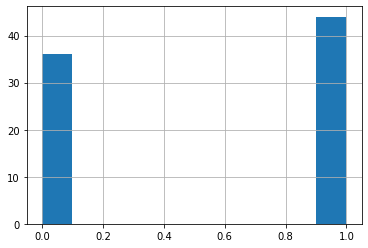

In [17]:
data.sentiment.hist()

In [18]:
data.shape

(80, 2)

In [19]:
data.drop_duplicates(inplace=True)

In [20]:
data.shape

(56, 2)

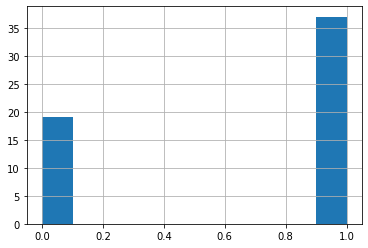

In [21]:
data.sentiment.hist()

## Remove punctudation

In [22]:
def remove_punctuation(text):
    if type(text) != str:
        return ''
    return text.translate(str.maketrans('', '', string.punctuation))

data['clean_text'] = data['text'].apply(remove_punctuation)

In [23]:
data.head()

,text,sentiment,clean_text
0,@PhilstarNews A dictator is a political leader...,0,PhilstarNews A dictator is a political leader ...
1,Watched #KatipsTheMovie in Manila so I feel yo...,0,Watched KatipsTheMovie in Manila so I feel you...
2,RT @__seav__: Yearly reminder: #MarcosNotAHero,0,RT seav Yearly reminder MarcosNotAHero
3,"RT @Frannyy: 11,103 film will premiere on Sep ...",0,RT Frannyy 11103 film will premiere on Sep 21 ...
4,@PhilstarNews Return what you and your family ...,0,PhilstarNews Return what you and your family s...


In [24]:
data = data.astype({'sentiment': 'int', 'clean_text': 'string'})

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.95, lowercase=True)  # ignore words with very high doc frequency
tf_idf = vectorizer.fit_transform(data['clean_text'])
words = vectorizer.get_feature_names_out()

In [27]:
from sklearn.preprocessing import normalize
tf_idf = normalize(tf_idf)

In [28]:
tf_idf = tf_idf.toarray()
tf_idf.shape

(56, 491)

In [29]:
y = data.sentiment
y.shape

(56,)

# Train data using various models

In [30]:
from sklearn.model_selection import train_test_split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf, y, test_size= .2)

In [45]:
1- np.mean(y_train) # naive accuracy baseline

0.34090909090909094

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

In [73]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=5)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=2)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31)
ada = AdaBoostClassifier()

In [74]:
classifiers = {'SVC' : svc,'KNeighborsClassifier' : knc, 'Multinomial Naive Bayes': mnb, 'Decision Tree': dtc, 'Logistic Regression': lrc, 'Random Forest': rfc, 'AdaBoost': ada}

In [75]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

In [77]:
model_pred_scores = []
for k, m in classifiers.items():
  m.fit(X_train, y_train)
  y_hat = m.predict(X_test)
  model_pred_scores.append((k, [accuracy_score(y_test , y_hat)]))

In [ ]:
cross_val_model_pred_scores = []
for k, m in classifiers.items():
  scores = cross_val_score(m, X_test, y_test, cv=5)
  cross_val_model_pred_scores.append((k, scores.mean()))

In [79]:
model_pred_scores

[('SVC', [1.0]),
 ('KNeighborsClassifier', [0.9166666666666666]),
 ('Multinomial Naive Bayes', [1.0]),
 ('Decision Tree', [0.9166666666666666]),
 ('Logistic Regression', [0.8333333333333334]),
 ('Random Forest', [0.9166666666666666]),
 ('AdaBoost', [0.9166666666666666])]

In [80]:
cross_val_model_pred_scores

[('SVC', 0.6666666666666666),
 ('KNeighborsClassifier', 0.6666666666666666),
 ('Multinomial Naive Bayes', 0.6666666666666666),
 ('Decision Tree', 0.8333333333333333),
 ('Logistic Regression', 0.4666666666666666),
 ('Random Forest', 0.8),
 ('AdaBoost', 0.8333333333333333)]